# Homework 2 ; ML
BAIM Mohamed Jalal

In [1]:
import numpy as np 
import struct
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import defaultdict
import math

## Image decompression

In [2]:
def read_idx_file(file_path):
    with open(file_path, 'rb') as f:
        print(f"Reading file: {file_path.split('/')[-1]}")
        magic_number = struct.unpack('>I', f.read(4))[0]

        num_items = struct.unpack('>I', f.read(4))[0]
        print(f"Number of Items: {num_items}")

        if 'images' in file_path:
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            print(f"Image Dimensions: {num_rows}x{num_cols}")

            item_data = f.read()
            items = np.frombuffer(item_data, dtype=np.uint8)
            items = items.reshape(num_items, num_rows, num_cols)
        else:
            label_data = f.read()
            items = np.frombuffer(label_data, dtype=np.uint8)

        print(f"Items array shape: {items.shape}")
        print("-"*50)
        return items

file_paths = ['./t10k-images.idx3-ubyte_', './t10k-labels.idx1-ubyte_', './train-images.idx3-ubyte_', './train-labels.idx1-ubyte_']
file_names = ['test_images', 'test_labels', 'train_images', 'train_labels']

data = {}
for file_path, file_name in zip(file_paths, file_names):
    data[file_name] = read_idx_file(file_path)


Reading file: t10k-images.idx3-ubyte_
Number of Items: 10000
Image Dimensions: 28x28
Items array shape: (10000, 28, 28)
--------------------------------------------------
Reading file: t10k-labels.idx1-ubyte_
Number of Items: 10000
Items array shape: (10000,)
--------------------------------------------------
Reading file: train-images.idx3-ubyte_
Number of Items: 60000
Image Dimensions: 28x28
Items array shape: (60000, 28, 28)
--------------------------------------------------
Reading file: train-labels.idx1-ubyte_
Number of Items: 60000
Items array shape: (60000,)
--------------------------------------------------


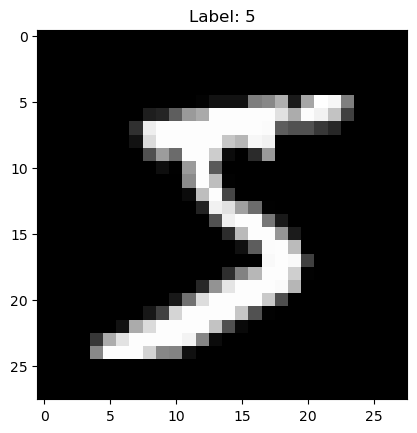

In [3]:
index = 0
image = data['train_images'][index]
label = data['train_labels'][index]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [4]:
Tooggle_option = 0 
# Tooggle_option = 0 discrete method
# Tooggle_option = 1 continous method

## Discrete mode

In [5]:
# I want to write 2 functions : discrete and continous modes where 

# discrete mode: 
# I will tally the frequency of the values of each pixel into 32 bins, 
# then perform naive bayes classifier, to avoid empty bins, I will use peudo count

# continous mode:
# I will use MLE to fit gaussian distribution to the pixel values of each pixel, 
# then perform naive bayes classifier

In [6]:
def discrete_naive_bayes(train_images, train_labels, test_images, test_labels):
    num_classes = 10
    num_train = len(train_images)
    num_test = len(test_images)
    num_rows, num_cols = train_images[0].shape
    num_pixels = num_rows * num_cols
    num_bins = 32 

    # Initialization
    class_counts = np.zeros(num_classes)
    pixel_bin_counts = np.zeros((num_classes, num_pixels, num_bins))

    # Training
    print("Training Naive Bayes classifier...")
    for i in range(num_train):
        label = train_labels[i]
        class_counts[label] += 1
        for row in range(num_rows):
            for col in range(num_cols):
                pixel_value = train_images[i][row][col]
                bin_idx = pixel_value // 8 # 256 / 8 = 32 bins
                pixel_bin_counts[label][row*num_cols + col][bin_idx] += 1

    priors = class_counts / num_train
    likelihoods = (pixel_bin_counts + 1) / (class_counts[:, None, None] + num_bins) # Laplace smoothing +1

    # Posteriors and error rate c
    print("Testing Naive Bayes classifier...")
    errors = 0
    for i in range(num_test):
        posteriors = np.zeros(num_classes)
        for class_idx in range(num_classes):
            log_posterior = math.log(priors[class_idx])
            for row in range(num_rows):
                for col in range(num_cols):
                    pixel_value = test_images[i][row][col]
                    bin_idx = pixel_value // 8
                    log_posterior += math.log(likelihoods[class_idx][row*num_cols + col][bin_idx])
            posteriors[class_idx] = log_posterior

        predicted_label = np.argmax(posteriors)

        print("Postirior (in log scale):")
        for label in range(num_classes):
            print(f"{label}: {posteriors[label]}")

        predicted_label = np.argmax(posteriors)
        print(f"Prediction: {predicted_label}, Ans: {test_labels[i]}")


        if predicted_label != test_labels[i]:
            errors += 1

    # Calculate and print the error rate
    error_rate = errors / num_test
    print(f"Error rate: {error_rate}")

    # Visualize the classifier's imagination of each digit
    print("\nImagination of digits in Naive Bayes classifier:")
    for class_idx in range(num_classes):
        print(f"\nDigit {class_idx}:")
        for row in range(num_rows):
            for col in range(num_cols):
                if np.argmax(likelihoods[class_idx][row*num_cols + col]) > 15:
                    print('1', end=' ')
                else:
                    print('0', end=' ')
            print()

discrete_naive_bayes(data['train_images'], data['train_labels'], data['test_images'], data['test_labels'])


Training Naive Bayes classifier...


KeyboardInterrupt: 

In [ ]:
def calculate_priors(labels, num_classes):
    priors = np.zeros(num_classes)
    for label in labels:
        priors[label] += 1
    return priors / len(labels)

def continuous_naive_bayes(train_images, train_labels, test_images, test_labels):
    num_classes = 10  # 10 digit classes (0-9)
    num_train, num_test = len(train_images), len(test_images)
    img_height, img_width = train_images[0].shape
    num_features = img_height * img_width

    # Flatten the images for simpler matrix operations
    train_images_flat = train_images.reshape(num_train, num_features)
    test_images_flat = test_images.reshape(num_test, num_features)

    # Step 1: Compute priors, means, and variances for each class
    priors = calculate_priors(train_labels, num_classes)
    means = np.zeros((num_classes, num_features))
    variances = np.zeros((num_classes, num_features))

    for c in range(num_classes):
        X_class = train_images_flat[train_labels == c]
        means[c, :] = np.mean(X_class, axis=0)
        variances[c, :] = np.var(X_class, axis=0) + 1e-2

    # Step 2: Test phase - calculate log-posteriors and make predictions
    log_posteriors = np.zeros((num_test, num_classes))
    errors = 0

    for i in range(num_test):
        print(f"Image {i}:")
        for c in range(num_classes):
            log_posteriors[i, c] = math.log(priors[c])
            for j in range(num_features):
                mean = means[c, j]
                var = variances[c, j]
                log_likelihood = -0.5 * np.log(2 * np.pi * var) - ((test_images_flat[i, j] - mean) ** 2) / (2 * var)
                log_posteriors[i, c] += log_likelihood
            print(f"{c}: {log_posteriors[i, c]}")
        
        predicted_label = np.argmax(log_posteriors[i])
        if predicted_label != test_labels[i]:
            errors += 1

    # Step 3: Calculate and print the error rate
    error_rate = errors / num_test
    print(f"Error rate: {error_rate}")

    print("\nClassifier's Imagination of Each Digit (based on means):")
    for c in range(num_classes):
        print(f"\nDigit {c}:")
        mean_image = means[c].reshape(img_height, img_width)
        for row in range(img_height):
            for col in range(img_width):
                if mean_image[row, col] > 127:
                    print('1', end=' ')
                else:
                    print('0', end=' ')
            print()

continuous_naive_bayes(data['train_images'], data['train_labels'], data['test_images'], data['test_labels'])

Image 0:
0: -6120124.147360981
1: -2293184.023458642
2: -6122014.267209374
3: -4010.3895418480283
4: -3544.299200810388
5: -3110.5650114429563
6: -7591097.886875749
7: -2252.019191365137
8: -4413.4522783806915
9: -2242.3946549091925
Image 1:
0: -43131.607233096685
1: -15729.518245673984
2: -2821.890661071682
3: -1232259.4595585782
4: -934806.6424072622
5: -7786.181702754536
6: -8049.269462553521
7: -15238696.572582072
8: -948161.1216439884
9: -12186075.444767803
Image 2:
0: -2653.37073486362
1: -1673.6904289802833
2: -2598.279266189501
3: -2441.2004812367322
4: -2474.7479465914307
5: -2480.233251017276
6: -2326.853988960848
7: -3629009.8525602533
8: -2308.7734395500224
9: -2811.2216016744096
Image 3:
0: -2284.7152782258963
1: -25625.131194179823
2: -2839.9046015625668
3: -2688.922054671537
4: -2848.0208174899863
5: -2680.4878641783052
6: -2451.6935989293693
7: -8029.403781142189
8: -2526.66678569642
9: -3164.065447697417
Image 4:
0: -2482.0185677294126
1: -12283.314112340548
2: -2746.1

## Online Learning 

In [17]:
def factorial(n):
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

def binomial_coefficient(n, k):
    if k > n:
        return 0
    return factorial(n) // (factorial(k) * factorial(n - k))

# Function to compute the likelihood based on MLE
def compute_likelihood(n, k):
    if n == 0:
        return 0
    p_hat = k / n
    coeff = binomial_coefficient(n, k)
    likelihood = coeff * (p_hat ** k) * ((1 - p_hat) ** (n - k))
    return likelihood

def update_beta_prior(a, b, k, n):
    a_new = a + k
    b_new = b + n - k
    return a_new, b_new

def read_data(file_path):
    data_lines = []
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip() 
                if not line:
                    continue 
                case_number = len(data_lines) + 1 
                data_lines.append((case_number, line))
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    return data_lines

# Main
def beta_binomial_online_learning(file_path, a_init, b_init):
    a = a_init
    b = b_init
    data_lines = read_data(file_path)

    if not data_lines:
        print("No data found in the file.")
        return

    for idx, (case_number, data_str) in enumerate(data_lines, 1):
        data = [int(bit) for bit in data_str if bit in '01']
        n = len(data)
        k = sum(data)

        if n == 0:
            print(f"Case {case_number}: {data_str}")
            print("No data available.\n")
            continue

        likelihood = compute_likelihood(n, k)

        print(f"Case {case_number}: {data_str}")
        print(f"Number of trials (n): {n}")
        print(f"Number of successes (k): {k}")
        print(f"Likelihood: {likelihood:.6f}")
        print(f"Beta prior: a = {a}, b = {b}")

        a, b = update_beta_prior(a, b, k, n)

        print(f"Beta posterior: a = {a}, b = {b}\n")

file_path = 'test_file.txt'
a_init = 10
b_init = 1

beta_binomial_online_learning(file_path, a_init, b_init)

Case 1: 0101010101001011010101
Number of trials (n): 22
Number of successes (k): 11
Likelihood: 0.168188
Beta prior: a = 10, b = 1
Beta posterior: a = 21, b = 12

Case 2: 0110101
Number of trials (n): 7
Number of successes (k): 4
Likelihood: 0.293755
Beta prior: a = 21, b = 12
Beta posterior: a = 25, b = 15

Case 3: 010110101101
Number of trials (n): 12
Number of successes (k): 7
Likelihood: 0.228605
Beta prior: a = 25, b = 15
Beta posterior: a = 32, b = 20

Case 4: 0101101011101011010
Number of trials (n): 19
Number of successes (k): 11
Likelihood: 0.182869
Beta prior: a = 32, b = 20
Beta posterior: a = 43, b = 28

Case 5: 111101100011110
Number of trials (n): 15
Number of successes (k): 10
Likelihood: 0.214307
Beta prior: a = 43, b = 28
Beta posterior: a = 53, b = 33

Case 6: 101110111000110
Number of trials (n): 15
Number of successes (k): 9
Likelihood: 0.206598
Beta prior: a = 53, b = 33
Beta posterior: a = 62, b = 39

Case 7: 1010010111
Number of trials (n): 10
Number of successes